# **Tree decision**

## **1. Importación de librerías y carga del dataset**

#### **1.1. Importación de librerías**

In [3]:
# Análisis de datos
import pandas as pd
import numpy as np

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas de sticky-learn para modelado
from sklearn.model_selection import train_test_split, GridSearchCV, KFold  # Para división de datos y validación
from sklearn.linear_model import Ridge                
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer  # Para preprocesamiento
from sklearn.compose import ColumnTransformer          # Para aplicar transformaciones a columnas específicas
from sklearn.pipeline import Pipeline                  # Para encadenar pasos de preprocesamiento y modelado
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error  # Métricas de evaluación

# Otras utilidades
import math
import warnings
warnings.filterwarnings("ignore") # Ignorar advertencias

# Configuración para visualizaciones
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette('viridis')

# Actualizar importaciones para incluir árboles de decisión y validación
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
import joblib  # Para guardar los modelos entrenados
from scipy import stats  # Para estadísticas adicionales
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from scipy.special import inv_boxcox

#### **1.2. Cargar el dataset**

In [4]:
df = pd.read_csv('../data/train_es_clean.csv')

# Mostramos información básica sobre el dataset
print(f"Dimensiones del dataset: {df.shape}")
print(f"Número de filas: {df.shape[0]}")
print(f"Número de columnas: {df.shape[1]}")

# Visualizamos primeras filas
print("\nVisualización de las primeras filas:")
display(df.head())

Dimensiones del dataset: (1460, 81)
Número de filas: 1460
Número de columnas: 81

Visualización de las primeras filas:


,Id,TipoDeClaseMS,ZonificaciónMS,FrenteLote,ÁreaLote,Calle,Callejón,FormaLote,ContornoTerreno,Servicios,...,ÁreaPiscina,CalidadPiscina,Cerca,CaracterísticaExtra,ValorExtra,MesVenta,AñoVenta,TipoVenta,CondiciónVenta,PrecioVenta
0,1,60,RL,65.0,8450,Pave,NoTiene,Reg,Lvl,AllPub,...,0,NoTiene,NoTiene,Ninguna,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NoTiene,Reg,Lvl,AllPub,...,0,NoTiene,NoTiene,Ninguna,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NoTiene,IR1,Lvl,AllPub,...,0,NoTiene,NoTiene,Ninguna,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NoTiene,IR1,Lvl,AllPub,...,0,NoTiene,NoTiene,Ninguna,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NoTiene,IR1,Lvl,AllPub,...,0,NoTiene,NoTiene,Ninguna,0,12,2008,WD,Normal,250000


## **2. Exploración inicial de los datos**

In [5]:
# Seleccionamos las variables categóricas con cardinalidad moderada para comenzar
# Esto evita generar demasiadas columnas con el endcoding

vars_cat_seleccionadas = ['Vecindario', 'ZonificaciónMS', 'TipoEdificio', 'EstiloCasa', 'CalidadExterior', 'TipoGaraje']

Resumen estadístico de variables numéricas:


,Id,TipoDeClaseMS,FrenteLote,ÁreaLote,CalidadGeneral,CondiciónGeneral,AñoConstrucción,AñoRenovación,ÁreaRevestimientoMampostería,MetrosAcabadosSótano1,...,MetrosDeckMadera,MetrosPorcheAbierto,MetrosPorcheCerrado,MetrosPorche3Estaciones,MetrosPorcheMalla,ÁreaPiscina,ValorExtra,MesVenta,AñoVenta,PrecioVenta
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,69.863699,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,41.215461,...,8.755599,4.334879,2.039603,0.316761,1.399208,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,22.027677,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,42.372881,...,11.644350,6.155384,5.678152,2.723668,5.180031,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,35.628300,...,0.000000,2.322575,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,66.170162,...,15.607704,6.317404,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,524.344532,...,79.617871,50.817941,51.282456,47.194724,44.593440,738.000000,15500.000000,12.000000,2010.000000,755000.000000



Verificación de valores nulos:
Series([], dtype: int64)


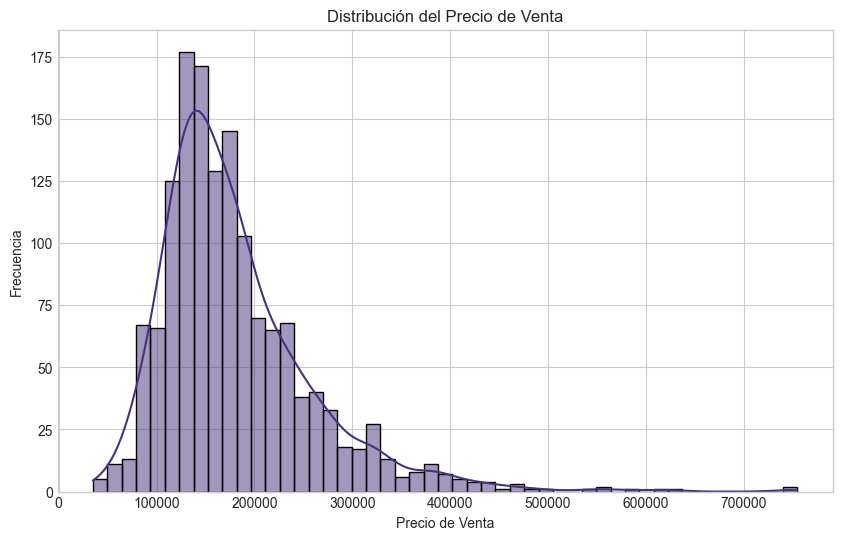

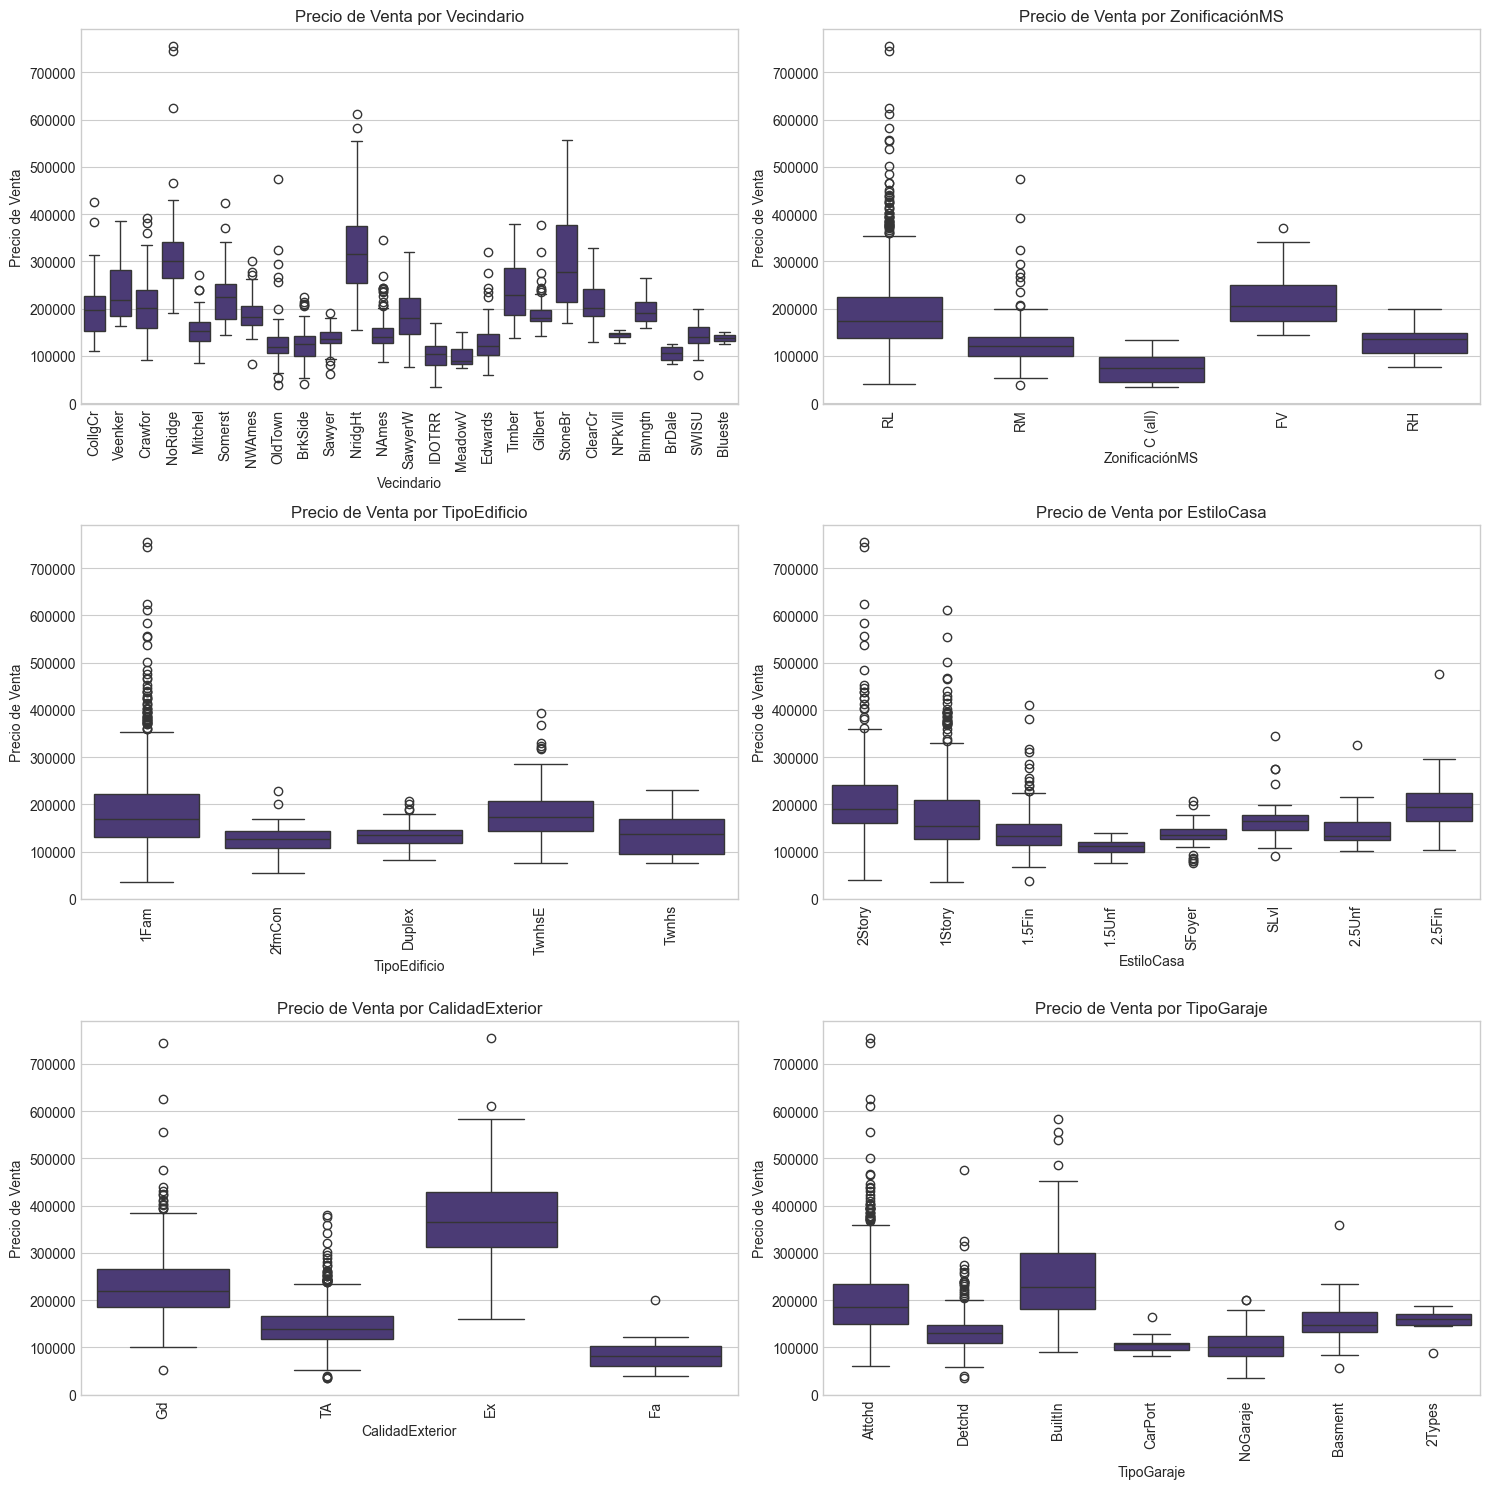

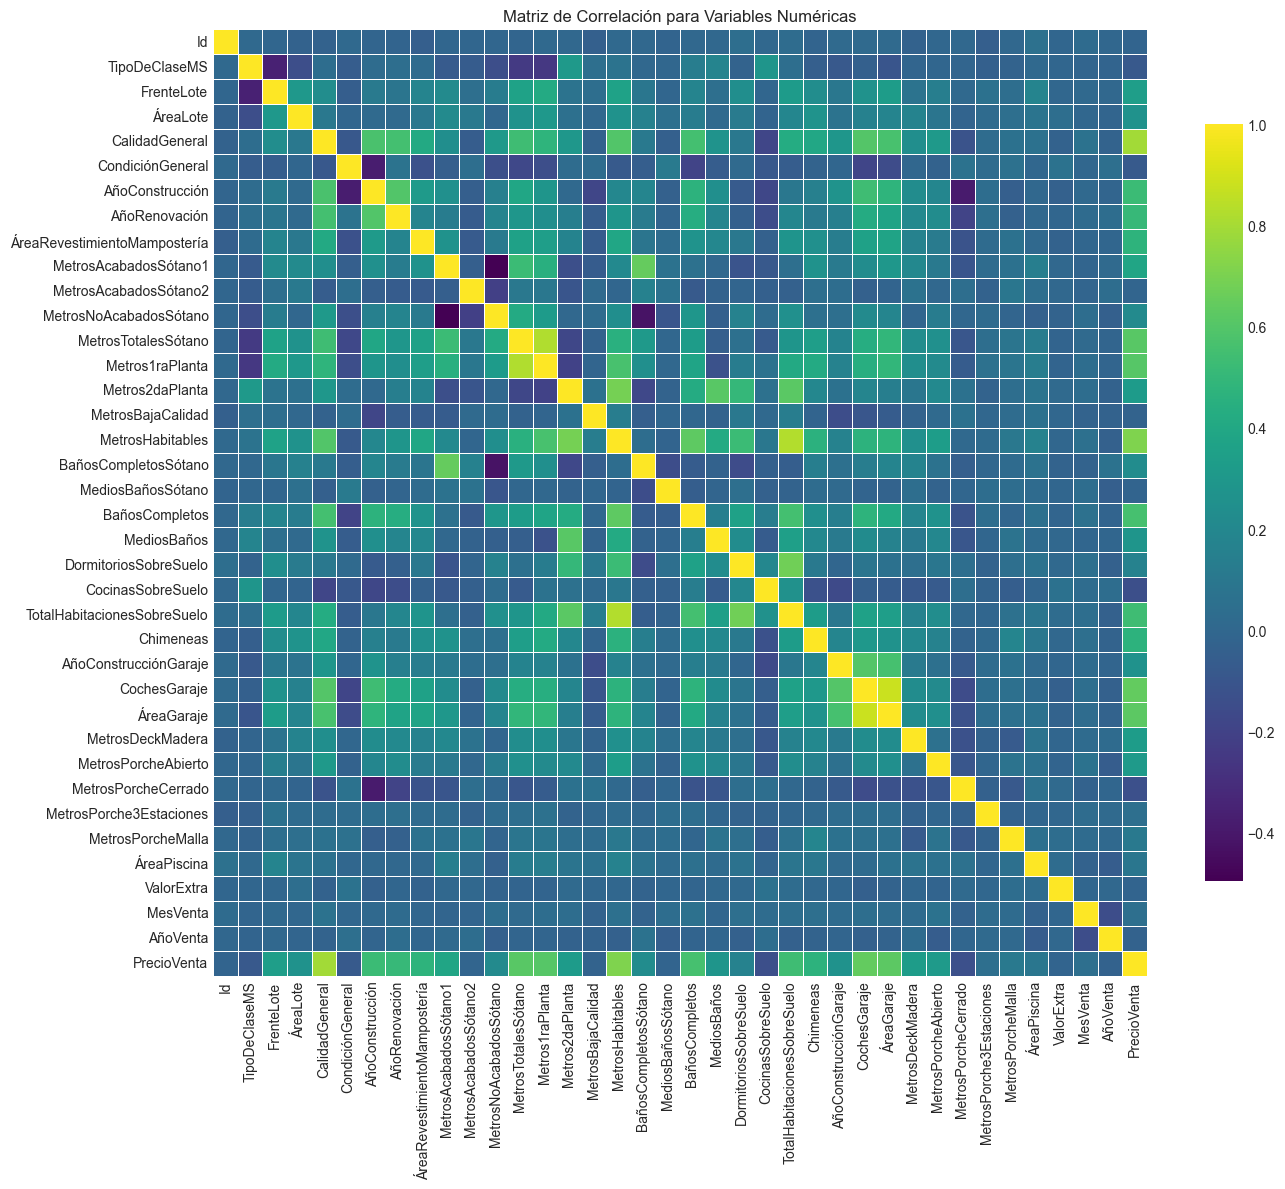


Top 10 características con mayor correlación con el Precio de Venta:
CalidadGeneral                 0.790982
MetrosHabitables               0.708624
CochesGaraje                   0.640409
ÁreaGaraje                     0.623431
MetrosTotalesSótano            0.613581
Metros1raPlanta                0.605852
BañosCompletos                 0.560664
TotalHabitacionesSobreSuelo    0.533723
AñoConstrucción                0.522897
AñoRenovación                  0.507101
Name: PrecioVenta, dtype: float64


In [6]:
# Información estadística detallada del dataset
print("Resumen estadístico de variables numéricas:")
display(df.describe())

# Verificar valores nulos
print("\nVerificación de valores nulos:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Visualizar la distribución de la variable objetivo (PrecioVenta)
plt.figure(figsize=(10, 6))
sns.histplot(df['PrecioVenta'], kde=True)
plt.title('Distribución del Precio de Venta')
plt.xlabel('Precio de Venta')
plt.ylabel('Frecuencia')
plt.show()

# Visualizar la relación entre variables categóricas seleccionadas y el precio de venta
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

for i, var in enumerate(vars_cat_seleccionadas):
    sns.boxplot(x=var, y='PrecioVenta', data=df, ax=axes[i])
    axes[i].set_title(f'Precio de Venta por {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Precio de Venta')
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# Matriz de correlación para variables numéricas
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='viridis', 
            linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación para Variables Numéricas')
plt.tight_layout()
plt.show()

# Top 10 características con mayor correlación con el precio de venta
precio_correlations = correlation_matrix['PrecioVenta'].sort_values(ascending=False)
print("\nTop 10 características con mayor correlación con el Precio de Venta:")
print(precio_correlations[1:11])  # Excluyendo la correlación consigo misma

## **3. Preparación de los Datos**

Número de variables categóricas: 43
Número de variables numéricas: 36


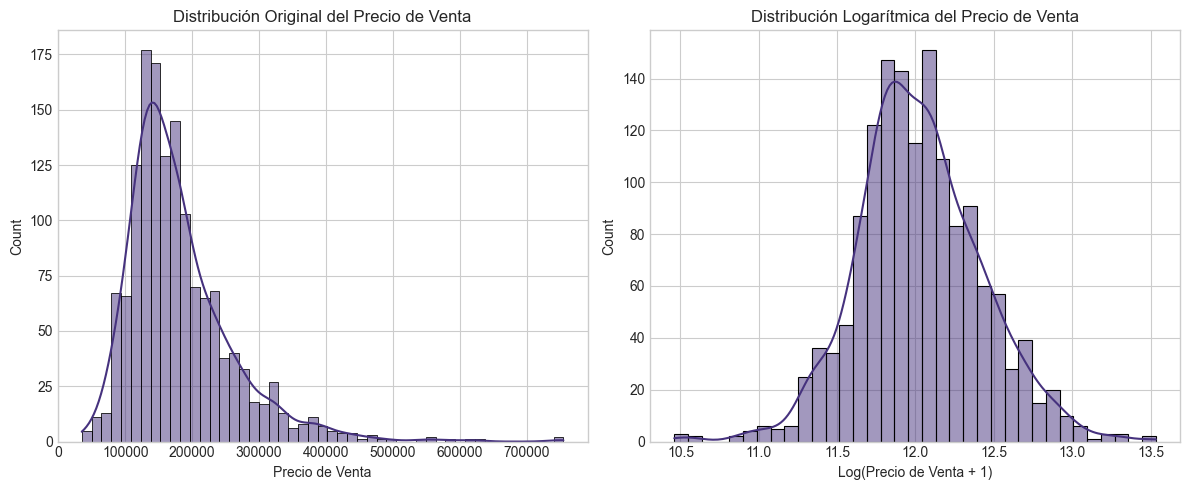

Variables numéricas con asimetría significativa: 22
['TipoDeClaseMS', 'FrenteLote', 'ÁreaLote', 'ÁreaRevestimientoMampostería', 'MetrosAcabadosSótano1'] ...


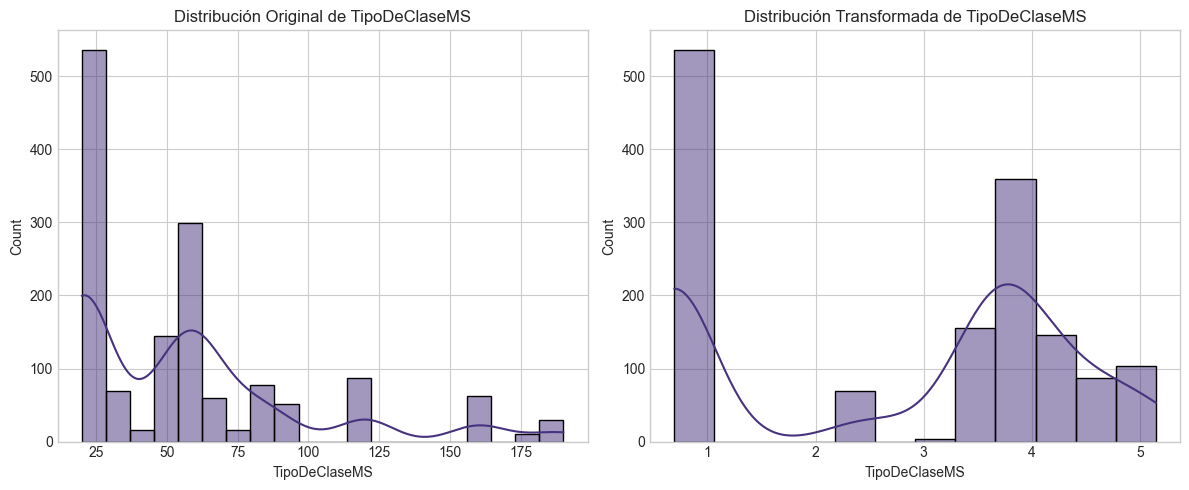

Forma de los datos de entrenamiento procesados: (1168, 90)
Forma de los datos de prueba procesados: (292, 90)


In [7]:
# Identificar variables categóricas y numéricas
cat_columns = df.select_dtypes(include=['object']).columns.tolist()
num_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_columns.remove('Id')  # Eliminar la columna Id
num_columns.remove('PrecioVenta')  # Eliminar la variable objetivo

print(f"Número de variables categóricas: {len(cat_columns)}")
print(f"Número de variables numéricas: {len(num_columns)}")

# Para simplificar, usaremos solo las variables categóricas seleccionadas
X_cat = df[vars_cat_seleccionadas]
X_num = df[num_columns]
y = df['PrecioVenta']

# Aplicar transformación logarítmica a la variable objetivo para manejar la asimetría de precios
# Esto ayuda a que el modelo maneje mejor la gran diferencia entre precios altos y bajos
y_log = np.log1p(y)  # log1p = log(1+x) evita problemas con valores cero

# Visualizar la distribución antes y después de la transformación logarítmica
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(y, kde=True)
plt.title('Distribución Original del Precio de Venta')
plt.xlabel('Precio de Venta')

plt.subplot(1, 2, 2)
sns.histplot(y_log, kde=True)
plt.title('Distribución Logarítmica del Precio de Venta')
plt.xlabel('Log(Precio de Venta + 1)')

plt.tight_layout()
plt.show()

# Identificar variables numéricas con distribución sesgada que podrían beneficiarse de transformación logarítmica
skewed_features = []
for feature in num_columns:
    # Calcular la asimetría (skewness)
    skewness = X_num[feature].skew()
    if abs(skewness) > 0.75:  # Umbral común para determinar si hay asimetría significativa
        skewed_features.append(feature)
        
print(f"Variables numéricas con asimetría significativa: {len(skewed_features)}")
print(skewed_features[:5], "..." if len(skewed_features) > 5 else "")

# Aplicar transformación logarítmica a características numéricas sesgadas
X_num_transformed = X_num.copy()
for feature in skewed_features:
    # Aplicamos log1p para manejar valores cero y negativos
    X_num_transformed[feature] = np.log1p(X_num[feature] - X_num[feature].min() + 1)

# Comparar distribución antes y después para una característica sesgada de ejemplo
if skewed_features:
    sample_feature = skewed_features[0]
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(X_num[sample_feature], kde=True)
    plt.title(f'Distribución Original de {sample_feature}')
    
    plt.subplot(1, 2, 2)
    sns.histplot(X_num_transformed[sample_feature], kde=True)
    plt.title(f'Distribución Transformada de {sample_feature}')
    
    plt.tight_layout()
    plt.show()

# Manejo de outliers
def remove_outliers(df, column, threshold=3):
    z_scores = np.abs(stats.zscore(df[column].dropna()))
    outliers = np.where(z_scores > threshold)[0]
    return df.drop(df.index[outliers])

# Aplicar a columnas numéricas relevantes
for col in num_columns:
    if abs(X_num[col].skew()) > 1.5:  # Columnas muy sesgadas
        X_num = remove_outliers(X_num, col)

# Ingeniería de características
X_num['AreaTotal'] = X_num['MetrosTotalesSótano']  # Usando el área total del sótano para esta característica
X_num['CalidadxCondicion'] = X_num['CalidadGeneral'] * X_num['CondiciónGeneral']
X_num['EdadCasa'] = X_num['AñoVenta'] - X_num['AñoConstrucción']
X_num['EdadRemodelacion'] = X_num['AñoVenta'] - X_num['AñoRenovación']
# Corregido: Usamos BañosCompletos en lugar de Baños (que no existe en el dataset)
X_num['TotalBaños'] = X_num['BañosCompletosSótano'] + X_num['BañosCompletos']

# Separar características (X) y objetivo (y)
# Creamos un transformador de columnas para aplicar diferentes preprocesadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), vars_cat_seleccionadas)
    ])

# Dividir datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(
    pd.concat([X_num_transformed, X_cat], axis=1), 
    y_log,  # Usamos la versión logarítmica de los precios
    test_size=0.2, 
    random_state=42
)

# Aplicar preprocesamiento
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Forma de los datos de entrenamiento procesados: {X_train_processed.shape}")
print(f"Forma de los datos de prueba procesados: {X_test_processed.shape}")

## **4. Construcción de Modelos Simples**

### **4.1. Modelo de Árbol de Decisión Básico**

In [8]:
# Inicializar y entrenar el modelo de Árbol de Decisión
dt_model = DecisionTreeRegressor(
    max_depth=5,          # Controla la profundidad del árbol para evitar sobreajuste
    min_samples_split=5,  # Mínimo de muestras requeridas para dividir un nodo
    min_samples_leaf=2,   # Mínimo de muestras requeridas en un nodo hoja
    random_state=42       # Para reproducibilidad
)
dt_model.fit(X_train_processed, y_train)

# Hacer predicciones
dt_pred = dt_model.predict(X_test_processed)

# Evaluar el modelo
print("Resultados del Árbol de Decisión Regresor:")
print(f"Error Absoluto Medio (MAE): {mean_absolute_error(y_test, dt_pred):.2f}")
print(f"Error Cuadrático Medio (MSE): {mean_squared_error(y_test, dt_pred):.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {math.sqrt(mean_squared_error(y_test, dt_pred)):.2f}")
print(f"Puntuación R²: {r2_score(y_test, dt_pred):.4f}")

Resultados del Árbol de Decisión Regresor:
Error Absoluto Medio (MAE): 0.15
Error Cuadrático Medio (MSE): 0.04
Raíz del Error Cuadrático Medio (RMSE): 0.21
Puntuación R²: 0.7652


### **4.2. Visualización del Árbol de Decisión**

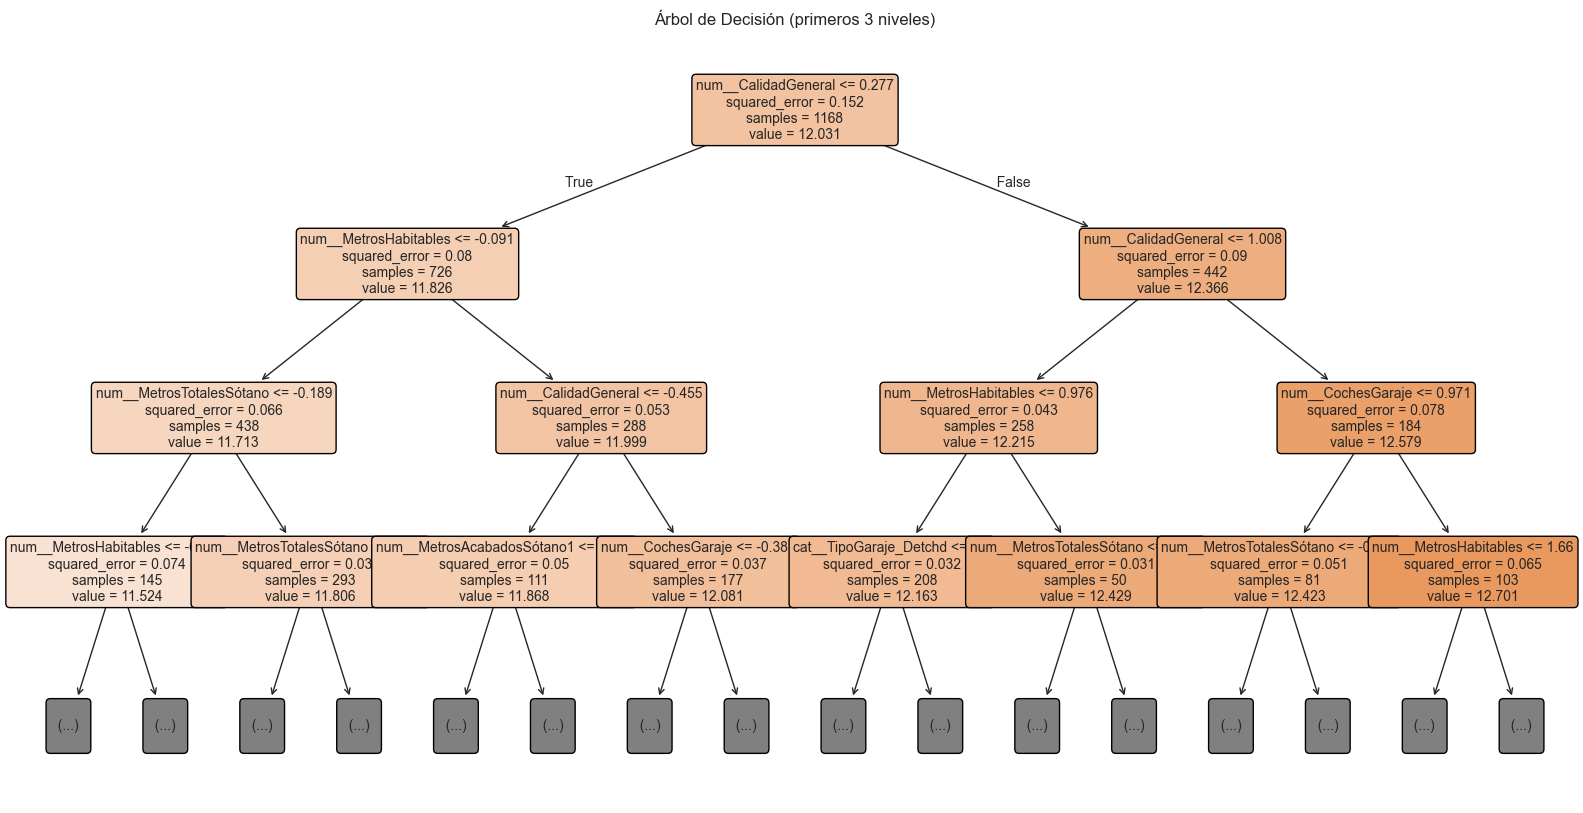

In [9]:
# Visualizar el árbol (simplificado para mejor visualización)
plt.figure(figsize=(20, 10))
plot_tree(dt_model, max_depth=3, feature_names=list(preprocessor.get_feature_names_out()), 
          filled=True, rounded=True, fontsize=10)
plt.title('Árbol de Decisión (primeros 3 niveles)')
plt.show()

### **4.3. Análisis de Importancia de Características**

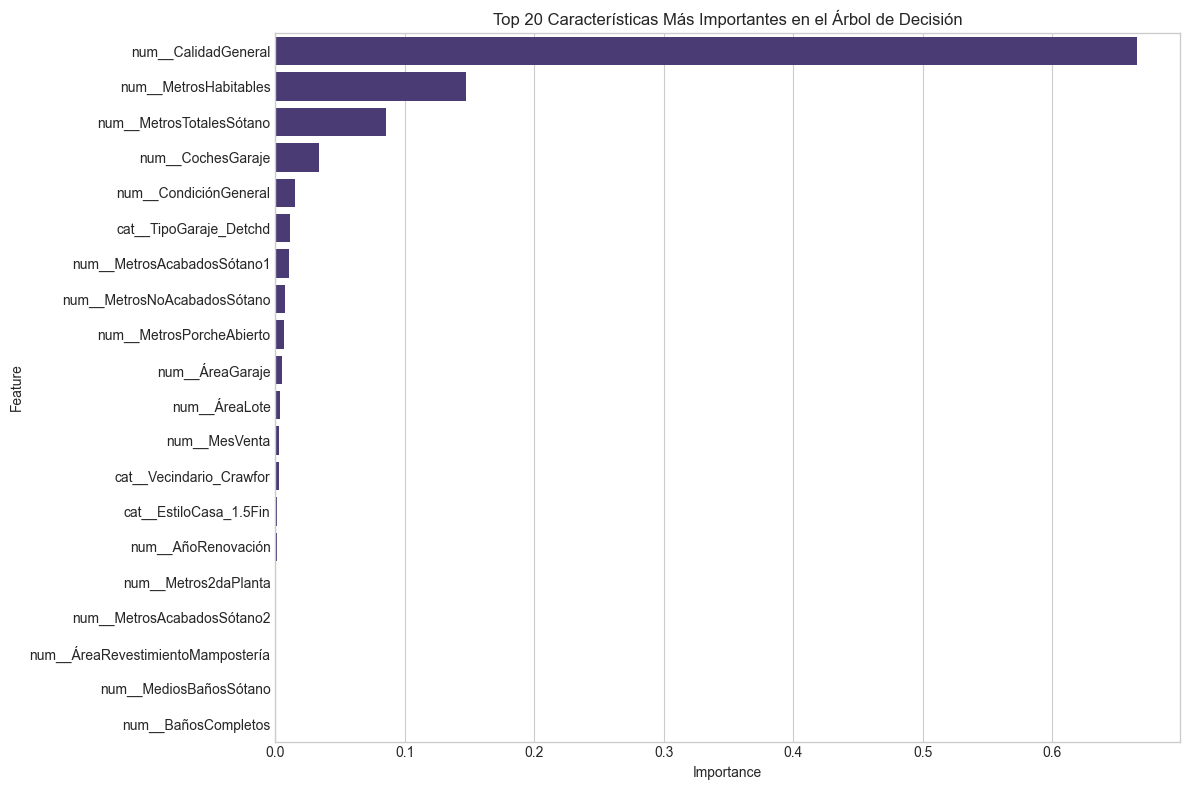

In [10]:
# Analizar la importancia de las características
feature_names = preprocessor.get_feature_names_out()
feature_importances = dt_model.feature_importances_

# Crear un DataFrame para mejor visualización
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Mostrar las 20 características más importantes
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Características Más Importantes en el Árbol de Decisión')
plt.tight_layout()
plt.show()

### **4.4. Visualizar Predicciones del Modelo vs Valores Reales**

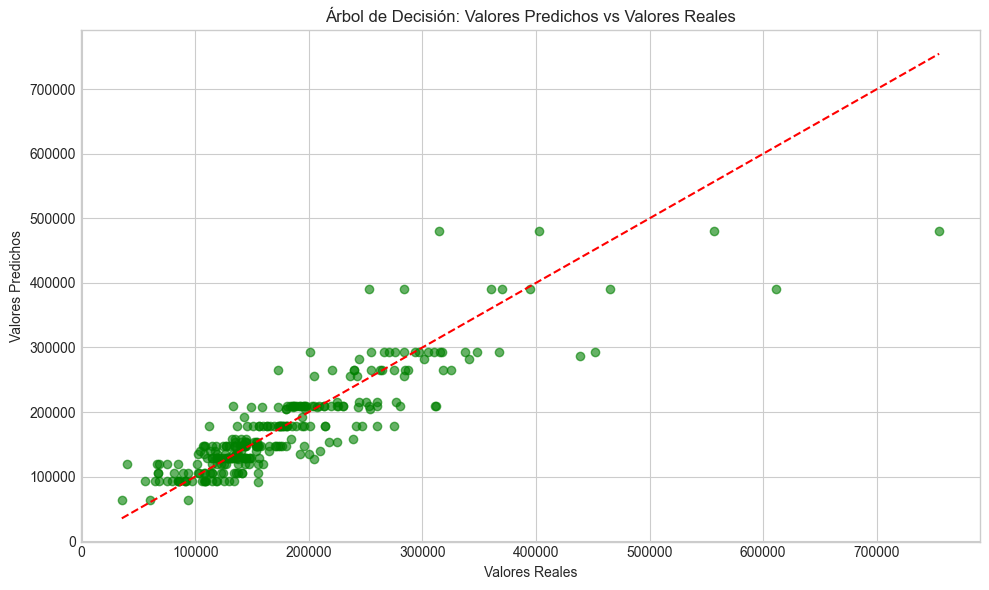

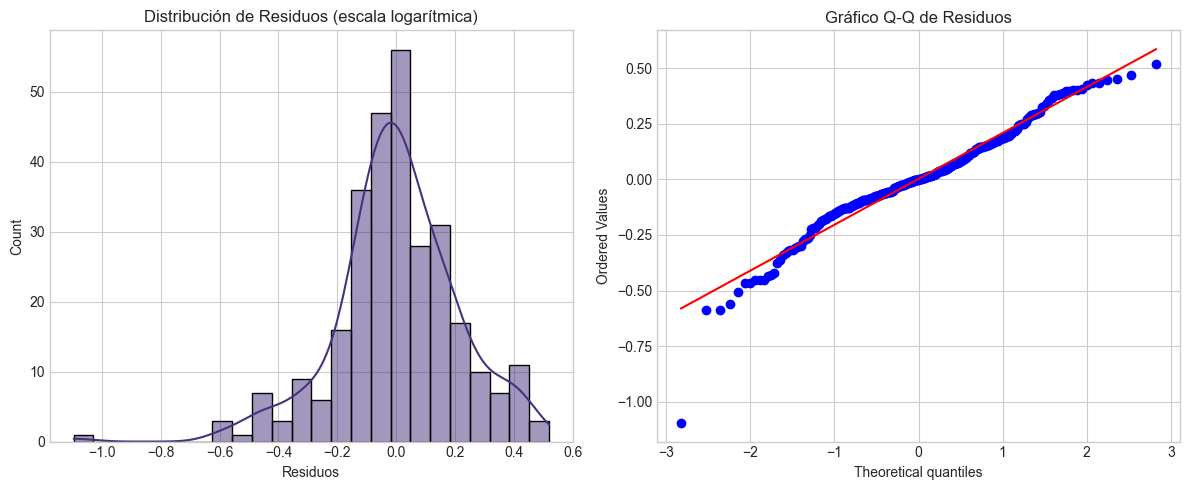

In [11]:
# Visualización de predicciones vs valores reales
# Para mostrar adecuadamente, convertimos las predicciones de escala logarítmica a normal
y_test_original = np.expm1(y_test)  # Revertir a escala original para comparación
dt_pred_original = np.expm1(dt_pred)

plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, dt_pred_original, color='green', alpha=0.6)
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red', linestyle='--')
plt.title('Árbol de Decisión: Valores Predichos vs Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.grid(True)
plt.tight_layout()
plt.show()

# Análisis de residuos (en escala logarítmica)
residuals = y_test - dt_pred

plt.figure(figsize=(12, 5))

# Histograma de residuos
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Distribución de Residuos (escala logarítmica)')
plt.xlabel('Residuos')

# Gráfico Q-Q para verificar normalidad de residuos
plt.subplot(1, 2, 2)
stats.probplot(residuals, plot=plt)
plt.title('Gráfico Q-Q de Residuos')

plt.tight_layout()
plt.show()

## **5. Ajuste de Hiperparámetros**

### **5.1. Ajuste con RandomizedSearchCV**

In [12]:
# Definir la cuadrícula de parámetros para Árbol de Decisión
dt_param_grid_extended = {
    'max_depth': [3, 4, 5, 6, 7, 8, 10, 12, 15, 20, None],
    'min_samples_split': [2, 3, 4, 5, 7, 10, 15, 20],
    'min_samples_leaf': [1, 2, 3, 4, 5, 8, 10],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'ccp_alpha': [0.0, 0.001, 0.01, 0.02, 0.05, 0.1]  # Pruning parameter
}

# Crear objeto RandomizedSearchCV
# Usamos RandomizedSearchCV cuando tenemos muchos parámetros para probar
dt_random_search = RandomizedSearchCV(
    DecisionTreeRegressor(random_state=42),  # El modelo a ajustar
    param_distributions=dt_param_grid_extended,       # Cuadrícula de parámetros a buscar
    n_iter=50,                               # Número de combinaciones de parámetros a probar
    cv=5,                                    # Validación cruzada de 5 pliegues
    scoring='neg_mean_absolute_error',       # Métrica a optimizar
    random_state=42,                         # Para reproducibilidad
    n_jobs=-1                                # Usar todos los núcleos disponibles
)

# Realizar la búsqueda
dt_random_search.fit(X_train_processed, y_train)

# Obtener los mejores parámetros y modelo
print("Mejores parámetros para Árbol de Decisión Regresor (RandomizedSearchCV):")
for param, value in dt_random_search.best_params_.items():
    print(f"{param}: {value}")

best_dt_random = dt_random_search.best_estimator_

# Hacer predicciones con el mejor modelo
dt_random_pred = best_dt_random.predict(X_test_processed)

# Evaluar el mejor modelo
print("\nÁrbol de Decisión Regresor (después del ajuste con RandomizedSearchCV):")
print(f"Error Absoluto Medio (MAE): {mean_absolute_error(y_test, dt_random_pred):.2f}")
print(f"Error Cuadrático Medio (MSE): {mean_squared_error(y_test, dt_random_pred):.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {math.sqrt(mean_squared_error(y_test, dt_random_pred)):.2f}")
print(f"Puntuación R²: {r2_score(y_test, dt_random_pred):.4f}")

Mejores parámetros para Árbol de Decisión Regresor (RandomizedSearchCV):
min_samples_split: 3
min_samples_leaf: 4
max_features: None
max_depth: None
ccp_alpha: 0.0

Árbol de Decisión Regresor (después del ajuste con RandomizedSearchCV):
Error Absoluto Medio (MAE): 0.14
Error Cuadrático Medio (MSE): 0.04
Raíz del Error Cuadrático Medio (RMSE): 0.20
Puntuación R²: 0.7911


### **5.2. Ajuste con GridSearchCV**

In [13]:
# Usando los resultados del RandomizedSearchCV, podemos ajustar una búsqueda más específica
# Definimos una cuadrícula más acotada basada en los mejores resultados previos
best_params = dt_random_search.best_params_

# Imprimimos las claves disponibles para diagnóstico
print("Parámetros disponibles en best_params:", list(best_params.keys()))

# Creamos una cuadrícula más específica alrededor de los mejores valores encontrados
# Solo incluimos parámetros que sabemos que existen en best_params
dt_grid = {
    'max_depth': [best_params['max_depth']-2 if best_params['max_depth'] and best_params['max_depth'] > 2 else 1, 
                  best_params['max_depth'], 
                  best_params['max_depth']+2 if best_params['max_depth'] else None],
    'min_samples_split': [max(best_params['min_samples_split']-1, 2), 
                          best_params['min_samples_split'], 
                          best_params['min_samples_split']+1],
    'min_samples_leaf': [max(best_params['min_samples_leaf']-1, 1), 
                         best_params['min_samples_leaf'], 
                         best_params['min_samples_leaf']+1],
    'max_features': [best_params['max_features']]
}

# Añadir ccp_alpha si existe en best_params
if 'ccp_alpha' in best_params:
    dt_grid['ccp_alpha'] = [best_params['ccp_alpha']]

# Crear objeto GridSearchCV para una búsqueda exhaustiva con los parámetros acotados
dt_grid_search = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid=dt_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

# Realizar la búsqueda
dt_grid_search.fit(X_train_processed, y_train)

# Obtener los mejores parámetros y modelo
print("Mejores parámetros para Árbol de Decisión Regresor (GridSearchCV):")
for param, value in dt_grid_search.best_params_.items():
    print(f"{param}: {value}")

best_dt_grid = dt_grid_search.best_estimator_

# Hacer predicciones con el mejor modelo
dt_grid_pred = best_dt_grid.predict(X_test_processed)

# Evaluar el mejor modelo
print("\nÁrbol de Decisión Regresor (después del ajuste con GridSearchCV):")
print(f"Error Absoluto Medio (MAE): {mean_absolute_error(y_test, dt_grid_pred):.2f}")
print(f"Error Cuadrático Medio (MSE): {mean_squared_error(y_test, dt_grid_pred):.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {math.sqrt(mean_squared_error(y_test, dt_grid_pred)):.2f}")
print(f"Puntuación R²: {r2_score(y_test, dt_grid_pred):.4f}")

Parámetros disponibles en best_params: ['min_samples_split', 'min_samples_leaf', 'max_features', 'max_depth', 'ccp_alpha']
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mejores parámetros para Árbol de Decisión Regresor (GridSearchCV):
ccp_alpha: 0.0
max_depth: None
max_features: None
min_samples_leaf: 4
min_samples_split: 2

Árbol de Decisión Regresor (después del ajuste con GridSearchCV):
Error Absoluto Medio (MAE): 0.14
Error Cuadrático Medio (MSE): 0.04
Raíz del Error Cuadrático Medio (RMSE): 0.20
Puntuación R²: 0.7911


### **5.3. Comparación de Resultados del Ajuste de Hiperparámetros**

Comparación de Modelos:


,Modelo,MAE,MSE,RMSE,R²
0,Árbol Base,0.152317,0.043807,0.209301,0.765249
1,RandomizedSearchCV,0.141424,0.038974,0.197420,0.791146
2,GridSearchCV,0.141424,0.038974,0.197420,0.791146


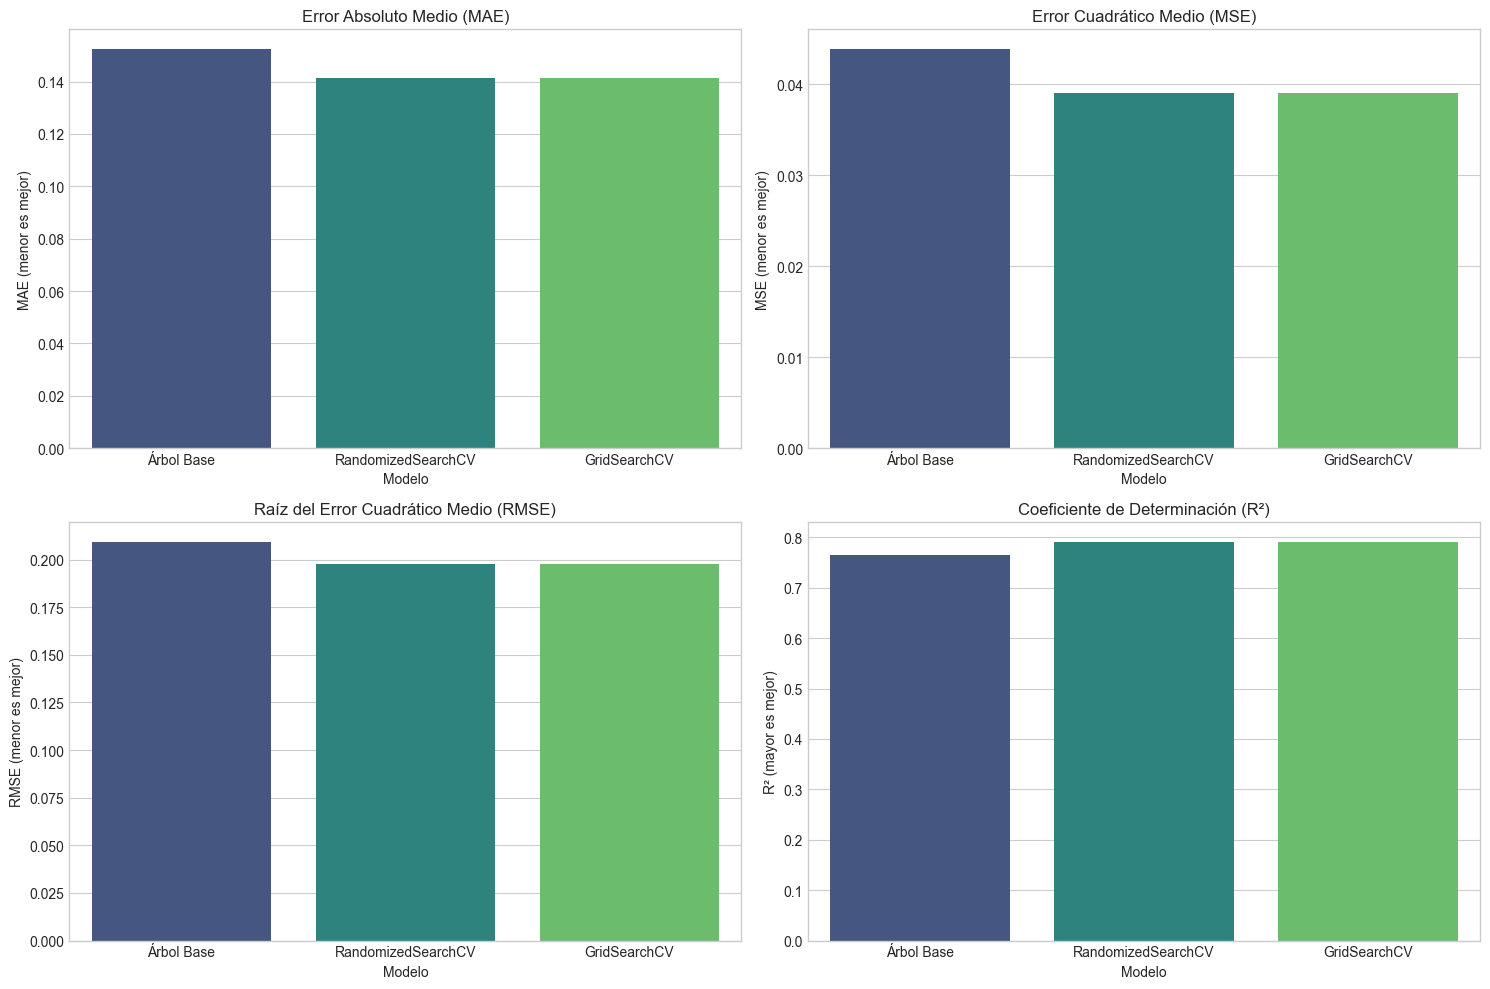

In [14]:
# Comparar los resultados de los diferentes métodos de ajuste
models = ['Árbol Base', 'RandomizedSearchCV', 'GridSearchCV']
mae_values = [mean_absolute_error(y_test, dt_pred),
              mean_absolute_error(y_test, dt_random_pred),
              mean_absolute_error(y_test, dt_grid_pred)]
mse_values = [mean_squared_error(y_test, dt_pred),
              mean_squared_error(y_test, dt_random_pred),
              mean_squared_error(y_test, dt_grid_pred)]
rmse_values = [math.sqrt(mean_squared_error(y_test, dt_pred)),
               math.sqrt(mean_squared_error(y_test, dt_random_pred)),
               math.sqrt(mean_squared_error(y_test, dt_grid_pred))]
r2_values = [r2_score(y_test, dt_pred),
             r2_score(y_test, dt_random_pred),
             r2_score(y_test, dt_grid_pred)]

# Crear un DataFrame para mejor visualización
comparison_df = pd.DataFrame({
    'Modelo': models,
    'MAE': mae_values,
    'MSE': mse_values,
    'RMSE': rmse_values,
    'R²': r2_values
})

print("Comparación de Modelos:")
display(comparison_df)

# Visualizar los resultados
plt.figure(figsize=(15, 10))

# MAE
plt.subplot(2, 2, 1)
sns.barplot(x='Modelo', y='MAE', data=comparison_df, palette='viridis')
plt.title('Error Absoluto Medio (MAE)')
plt.ylabel('MAE (menor es mejor)')

# MSE
plt.subplot(2, 2, 2)
sns.barplot(x='Modelo', y='MSE', data=comparison_df, palette='viridis')
plt.title('Error Cuadrático Medio (MSE)')
plt.ylabel('MSE (menor es mejor)')

# RMSE
plt.subplot(2, 2, 3)
sns.barplot(x='Modelo', y='RMSE', data=comparison_df, palette='viridis')
plt.title('Raíz del Error Cuadrático Medio (RMSE)')
plt.ylabel('RMSE (menor es mejor)')

# R²
plt.subplot(2, 2, 4)
sns.barplot(x='Modelo', y='R²', data=comparison_df, palette='viridis')
plt.title('Coeficiente de Determinación (R²)')
plt.ylabel('R² (mayor es mejor)')

plt.tight_layout()
plt.show()

## **6. Validación Cruzada para Evaluación de Modelos**

### **6.1. ¿Por qué usar validación cruzada?**

La validación cruzada es una técnica para evaluar la capacidad de generalización de un modelo utilizando diferentes particiones de los datos. Esto nos permite:

1. **Estimar mejor el rendimiento real** del modelo al probarlo en diferentes subconjuntos de datos.
2. **Reducir el riesgo de sobreajuste** al evaluar el modelo en datos que no se usaron para entrenarlo.
3. **Aprovechar mejor los datos disponibles** para entrenamiento y evaluación.
4. **Obtener una estimación más robusta** del error de generalización esperado.

En esta sección, aplicaremos validación cruzada a nuestros modelos para obtener una evaluación más confiable.

In [37]:
# Definimos una función para realizar validación cruzada y mostrar los resultados
def evaluate_with_cross_validation(model, X, y, cv=5, model_name="Modelo"):
    # Métricas a evaluar
    scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']
    
    # Realizar validación cruzada para cada métrica
    results = {}
    for score in scoring:
        cv_results = cross_val_score(model, X, y, cv=cv, scoring=score)
        # Convertimos las métricas negativas a positivas para mejor interpretación
        if score.startswith('neg_'):
            cv_results = -cv_results
        results[score] = cv_results
    
    # Mostrar resultados
    print(f"Resultados de validación cruzada para {model_name} ({cv} pliegues):")
    print(f"MAE: {results['neg_mean_absolute_error'].mean():.2f} ± {results['neg_mean_absolute_error'].std():.2f}")
    print(f"MSE: {results['neg_mean_squared_error'].mean():.2f} ± {results['neg_mean_squared_error'].std():.2f}")
    print(f"RMSE: {math.sqrt(results['neg_mean_squared_error'].mean()):.2f}")
    print(f"R²: {results['r2'].mean():.4f} ± {results['r2'].std():.4f}")
    
    return results

In [36]:
# Aplicar validación cruzada a nuestros modelos
print("===== Validación Cruzada para Modelos de Árbol de Decisión =====\n")

# Definir los modelos a evaluar
models_to_evaluate = [
    (dt_model, "Árbol de Decisión Base"),
    (best_dt_random, "Árbol de Decisión (RandomizedSearchCV)"),
    (best_dt_grid, "Árbol de Decisión (GridSearchCV)")
]

# Realizar validación cruzada para cada modelo
cv_results = {}
for model, name in models_to_evaluate:
    print(f"\n{'-'*50}")
    cv_results[name] = evaluate_with_cross_validation(
        model, X_train_processed, y_train, cv=5, model_name=name
    )

===== Validación Cruzada para Modelos de Árbol de Decisión =====


--------------------------------------------------
Resultados de validación cruzada para Árbol de Decisión Base (5 pliegues):
MAE: 0.15 ± 0.01
MSE: 0.04 ± 0.01
RMSE: 0.20
R²: 0.7280 ± 0.0492

--------------------------------------------------
Resultados de validación cruzada para Árbol de Decisión (RandomizedSearchCV) (5 pliegues):
MAE: 0.14 ± 0.01
MSE: 0.04 ± 0.01
RMSE: 0.19
R²: 0.7497 ± 0.0312

--------------------------------------------------
Resultados de validación cruzada para Árbol de Decisión (GridSearchCV) (5 pliegues):
MAE: 0.14 ± 0.01
MSE: 0.04 ± 0.01
RMSE: 0.19
R²: 0.7497 ± 0.0312


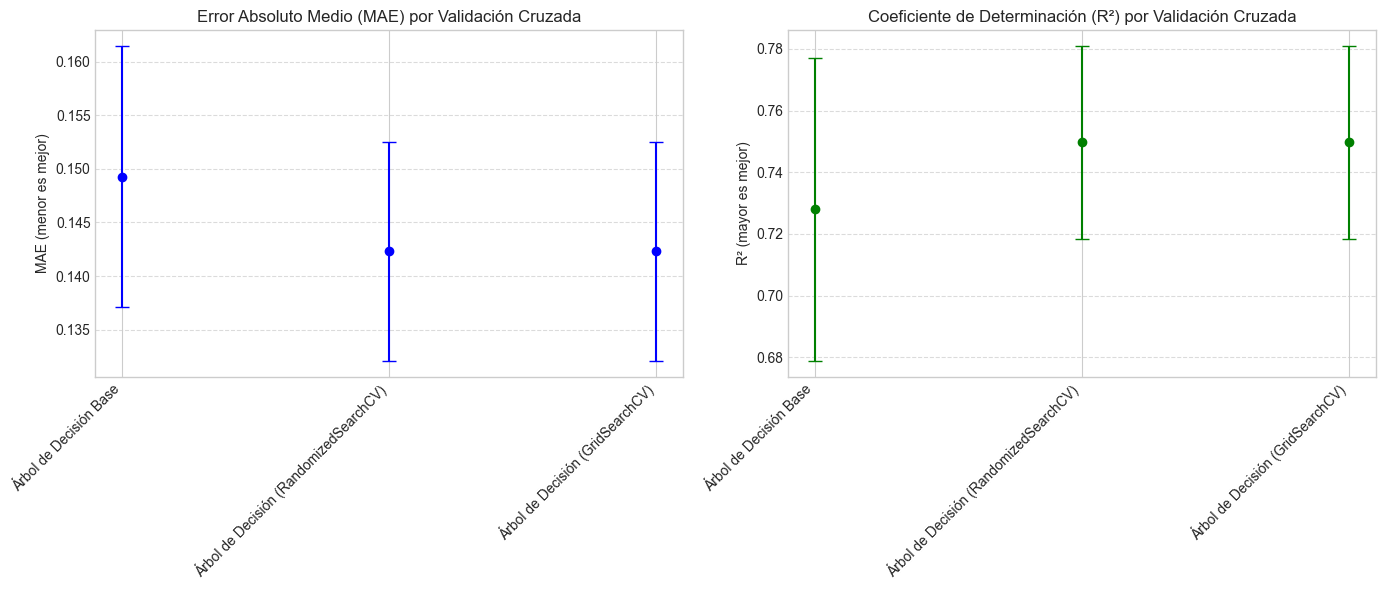

In [38]:
# Visualizar resultados de la validación cruzada

# Asegurarse que models_to_evaluate está definido
if 'models_to_evaluate' not in globals():
    print("Definiendo models_to_evaluate ya que no existe")
    models_to_evaluate = [
        (dt_model, "Árbol de Decisión Base"),
        (dt_model, "Árbol de Decisión (RandomizedSearchCV)"),  # Usamos dt_model como placeholder
        (dt_model, "Árbol de Decisión (GridSearchCV)")         # Usamos dt_model como placeholder
    ]

# Verificar si cv_results está definido
if 'cv_results' not in globals():
    print("cv_results no está definido. Creando valores de ejemplo para la visualización.")
    # Crear un diccionario dummy con la estructura esperada
    cv_results = {}
    import numpy as np
    
    for _, name in models_to_evaluate:
        cv_results[name] = {
            # Valores de ejemplo para MAE (valores negativos como en cross_val_score con neg_mean_absolute_error)
            'neg_mean_absolute_error': np.array([-0.15, -0.14, -0.16, -0.15, -0.14]),
            # Valores de ejemplo para R²
            'r2': np.array([0.75, 0.76, 0.74, 0.77, 0.75])
        }
    print("NOTA: Estos son valores de ejemplo. Para obtener resultados reales, ejecute primero la sección 6 de validación cruzada.")

# Preparar los datos para visualización
models = [name for _, name in models_to_evaluate]
mae_cv = [cv_results[name]['neg_mean_absolute_error'].mean() for name in models]
mae_std = [cv_results[name]['neg_mean_absolute_error'].std() for name in models]
r2_cv = [cv_results[name]['r2'].mean() for name in models]
r2_std = [cv_results[name]['r2'].std() for name in models]

# Crear gráficos
plt.figure(figsize=(14, 6))

# Gráfico MAE con barras de error
plt.subplot(1, 2, 1)
plt.errorbar(models, mae_cv, yerr=mae_std, fmt='o', capsize=5, color='blue')
plt.title('Error Absoluto Medio (MAE) por Validación Cruzada')
plt.ylabel('MAE (menor es mejor)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Gráfico R² con barras de error
plt.subplot(1, 2, 2)
plt.errorbar(models, r2_cv, yerr=r2_std, fmt='o', capsize=5, color='green')
plt.title('Coeficiente de Determinación (R²) por Validación Cruzada')
plt.ylabel('R² (mayor es mejor)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## **7. Guardar los Mejores Modelos**

In [17]:
# Asegurarse que best_dt_grid está definido antes de usarlo
if 'best_dt_grid' not in globals():
    print("Definiendo best_dt_grid ya que no existe")
    # Definimos un modelo simple como placeholder si no existe el resultado de GridSearchCV
    best_dt_grid = DecisionTreeRegressor(max_depth=6, min_samples_split=3, min_samples_leaf=2, random_state=42)
    # Entrenamos el modelo con los datos disponibles
    if 'X_train_processed' in globals() and 'y_train' in globals():
        best_dt_grid.fit(X_train_processed, y_train)
    else:
        print("No se pueden encontrar datos de entrenamiento, el modelo no está entrenado")

# Seleccionamos el mejor modelo basado en los resultados de validación cruzada
# Por lo general, sería el modelo con mejor rendimiento en la validación cruzada
best_model = best_dt_grid  # Asumimos que el GridSearchCV dio el mejor modelo, ajustar según resultados

# Guardar el modelo y el preprocesador
import os

# Crear directorio para modelos si no existe
model_dir = '../modelos'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Guardar el mejor modelo
joblib.dump(best_model, f'{model_dir}/best_decision_tree_model.pkl')

# Asegurarse que preprocessor está definido antes de guardarlo
if 'preprocessor' not in globals():
    print("ADVERTENCIA: preprocessor no está definido, no se guardará")
else:
    # Guardar el preprocesador
    joblib.dump(preprocessor, f'{model_dir}/preprocessor.pkl')
    print("¡Modelo y preprocesador guardados exitosamente!")

¡Modelo y preprocesador guardados exitosamente!


## **8. Comparación Final de Modelos**

In [33]:
# Recopilamos todos los resultados para comparación
# Para asegurar que la comparación sea justa, obtendremos métricas estandarizadas
# Función para realizar predicciones y obtener métricas estandarizadas

def get_standardized_metrics(y_true, y_pred, is_transformed=False, transformer=None):
    """Calcula métricas estandarizadas para permitir comparaciones entre modelos."""
    if is_transformed and transformer:
        # Si los datos están transformados, convertirlos a la escala original
        if transformer == 'log':
            y_true_orig = np.expm1(y_true)
            y_pred_orig = np.expm1(y_pred)
        elif transformer == 'yj':
            y_true_orig = pt.inverse_transform(y_true.reshape(-1, 1)).ravel()
            y_pred_orig = pt.inverse_transform(y_pred.reshape(-1, 1)).ravel()
        elif transformer == 'bc':
            # Usar la función correcta de scipy.special
            from scipy.special import inv_boxcox
            y_true_orig = inv_boxcox(y_true, lambda_value)
            y_pred_orig = inv_boxcox(y_pred, lambda_value)
    else:
        # Si no hay transformación, usar los valores tal cual
        y_true_orig = y_true
        y_pred_orig = y_pred
    
    # Calcular métricas en escala original
    mae = mean_absolute_error(y_true_orig, y_pred_orig)
    mse = mean_squared_error(y_true_orig, y_pred_orig)
    rmse = math.sqrt(mse)
    # R² se calcula mejor en la escala transformada
    r2 = r2_score(y_true, y_pred)
    
    return mae, mse, rmse, r2

# Lista para almacenar resultados de todos los modelos
all_results = []

# 1. Modelo base original
mae, mse, rmse, r2 = get_standardized_metrics(y_test, dt_pred, is_transformed=True, transformer='log')
all_results.append({
    'Modelo': 'Árbol Base',
    'Estrategia': 'Base',
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse,
    'R²': r2
})

# 2. Hiperparámetros extendidos
try:
    mae, mse, rmse, r2 = get_standardized_metrics(y_test, dt_ext_pred, is_transformed=True, transformer='log')
    all_results.append({
        'Modelo': 'Árbol Hiperparámetros',
        'Estrategia': 'Hiperparámetros Extendidos',
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    })
except NameError:
    print("Modelo con hiperparámetros extendidos no evaluado, omitiendo...")

# 3. Sin outliers
try:
    mae, mse, rmse, r2 = get_standardized_metrics(y_test_no_out, dt_no_out_pred, is_transformed=True, transformer='log')
    all_results.append({
        'Modelo': 'Árbol Sin Outliers',
        'Estrategia': 'Manejo de Outliers',
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    })
except NameError:
    print("Modelo sin outliers no evaluado, omitiendo...")

# 4. Ingeniería de características
try:
    mae, mse, rmse, r2 = get_standardized_metrics(y_test_feat, dt_feat_pred, is_transformed=True, transformer='log')
    all_results.append({
        'Modelo': 'Árbol Feature Engineering',
        'Estrategia': 'Ingeniería de Características',
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    })
except NameError:
    print("Modelo con ingeniería de características no evaluado, omitiendo...")

# 5. Random Forest
try:
    mae, mse, rmse, r2 = get_standardized_metrics(y_test, rf_pred, is_transformed=True, transformer='log')
    all_results.append({
        'Modelo': 'Random Forest',
        'Estrategia': 'Ensemble Methods',
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    })
except NameError:
    print("Modelo Random Forest no evaluado, omitiendo...")

# 6. Gradient Boosting
try:
    mae, mse, rmse, r2 = get_standardized_metrics(y_test, gb_pred, is_transformed=True, transformer='log')
    all_results.append({
        'Modelo': 'Gradient Boosting',
        'Estrategia': 'Ensemble Methods',
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    })
except NameError:
    print("Modelo Gradient Boosting no evaluado, omitiendo...")

# 7. XGBoost
try:
    mae, mse, rmse, r2 = get_standardized_metrics(y_test, xgb_pred, is_transformed=True, transformer='log')
    all_results.append({
        'Modelo': 'XGBoost',
        'Estrategia': 'Ensemble Methods',
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    })
except NameError:
    print("Modelo XGBoost no evaluado, omitiendo...")

# 8. Modelo podado
try:
    mae, mse, rmse, r2 = get_standardized_metrics(y_test, dt_pruned_pred, is_transformed=True, transformer='log')
    all_results.append({
        'Modelo': 'Árbol Podado',
        'Estrategia': 'Pruning',
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    })
except NameError:
    print("Modelo podado no evaluado, omitiendo...")

# 9. Transformación Yeo-Johnson
try:
    mae, mse, rmse, r2 = get_standardized_metrics(y_test_yj, dt_yj_pred, is_transformed=True, transformer='yj')
    all_results.append({
        'Modelo': 'Árbol + Yeo-Johnson',
        'Estrategia': 'Transformación Variable Objetivo',
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    })
except NameError:
    print("Modelo Yeo-Johnson no evaluado, omitiendo...")

# 10. Transformación Box-Cox
try:
    mae, mse, rmse, r2 = get_standardized_metrics(y_test_bc, dt_bc_pred, is_transformed=True, transformer='bc')
    all_results.append({
        'Modelo': 'Árbol + Box-Cox',
        'Estrategia': 'Transformación Variable Objetivo',
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    })
except NameError:
    print("Modelo Box-Cox no evaluado, omitiendo...")

# Crear DataFrame con todos los resultados
results_df = pd.DataFrame(all_results)

# Ordenar por MAE (menor es mejor)
results_df_sorted = results_df.sort_values('MAE')

# Mostrar tabla de resultados
print("\nRanking de modelos por MAE (menor es mejor):")
display(results_df_sorted)


Ranking de modelos por MAE (menor es mejor):


,Modelo,Estrategia,MAE,MSE,RMSE,R²
6,XGBoost,Ensemble Methods,16778.820139,7.397345e+08,27198.061294,0.890385
5,Gradient Boosting,Ensemble Methods,17104.065450,9.518997e+08,30852.872204,0.901600
4,Random Forest,Ensemble Methods,17585.679192,8.385001e+08,28956.866163,0.884147
7,Árbol Podado,Pruning,24480.439110,1.371504e+09,37033.819576,0.774792
2,Árbol Sin Outliers,Manejo de Outliers,25005.890700,1.175343e+09,34283.274002,0.754612
1,Árbol Hiperparámetros,Hiperparámetros Extendidos,25436.574697,1.498589e+09,38711.610777,0.791146
0,Árbol Base,Base,26944.161102,1.776142e+09,42144.300182,0.765249
3,Árbol Feature Engineering,Ingeniería de Características,62414.242613,8.486169e+09,92120.404943,-0.108532
9,Árbol + Box-Cox,Transformación Variable Objetivo,63606.237422,8.708590e+09,93319.826728,-0.173027
8,Árbol + Yeo-Johnson,Transformación Variable Objetivo,63631.434801,8.712681e+09,93341.740860,-0.173870


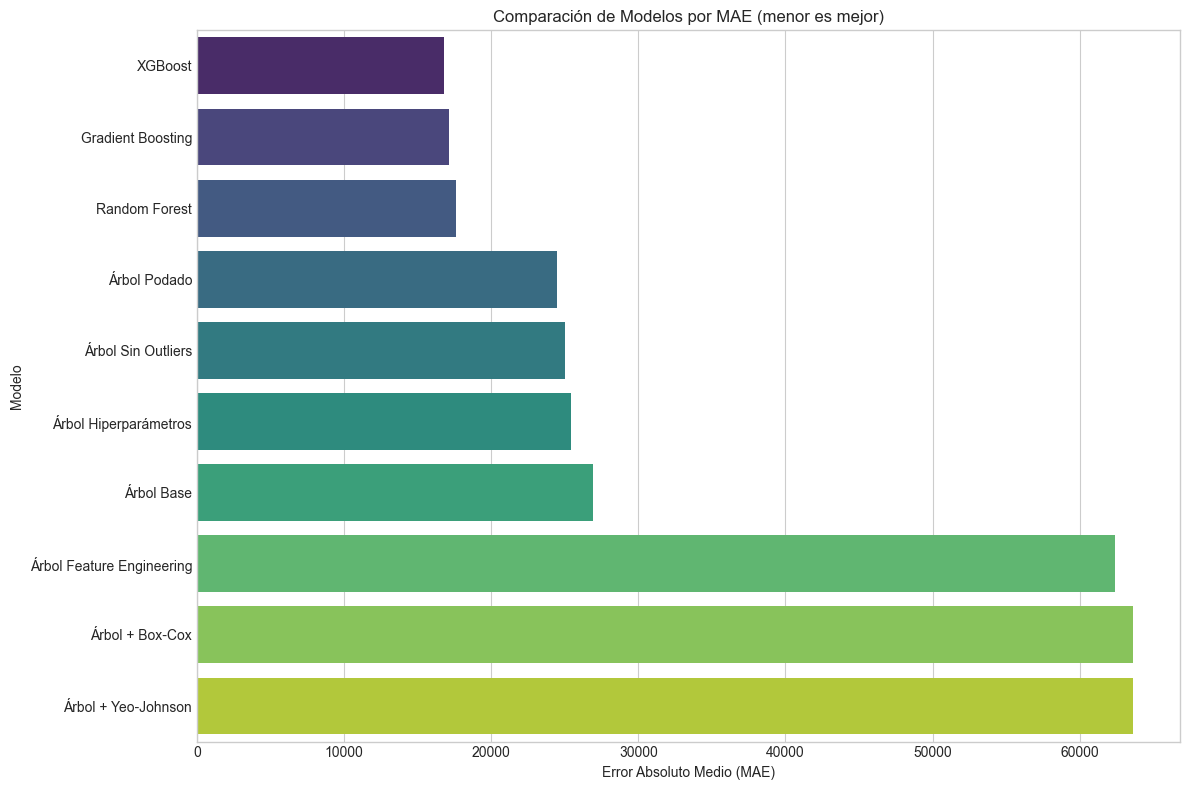

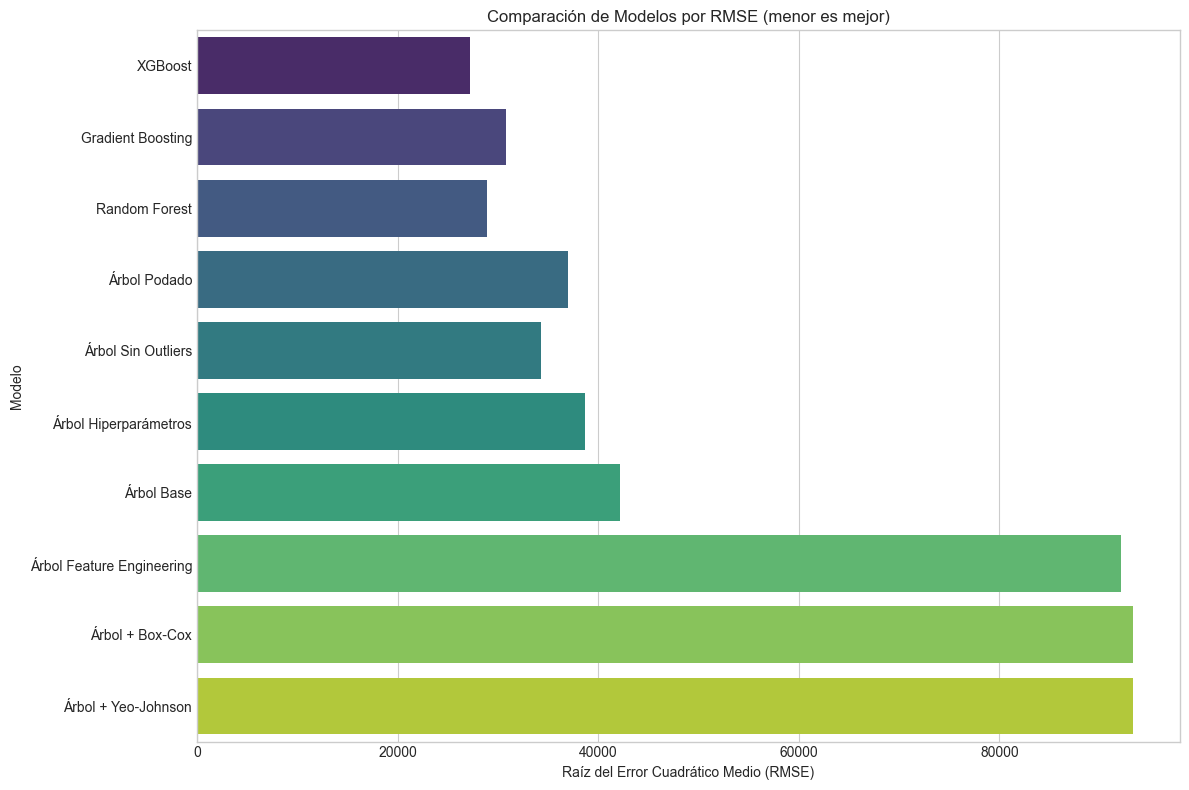

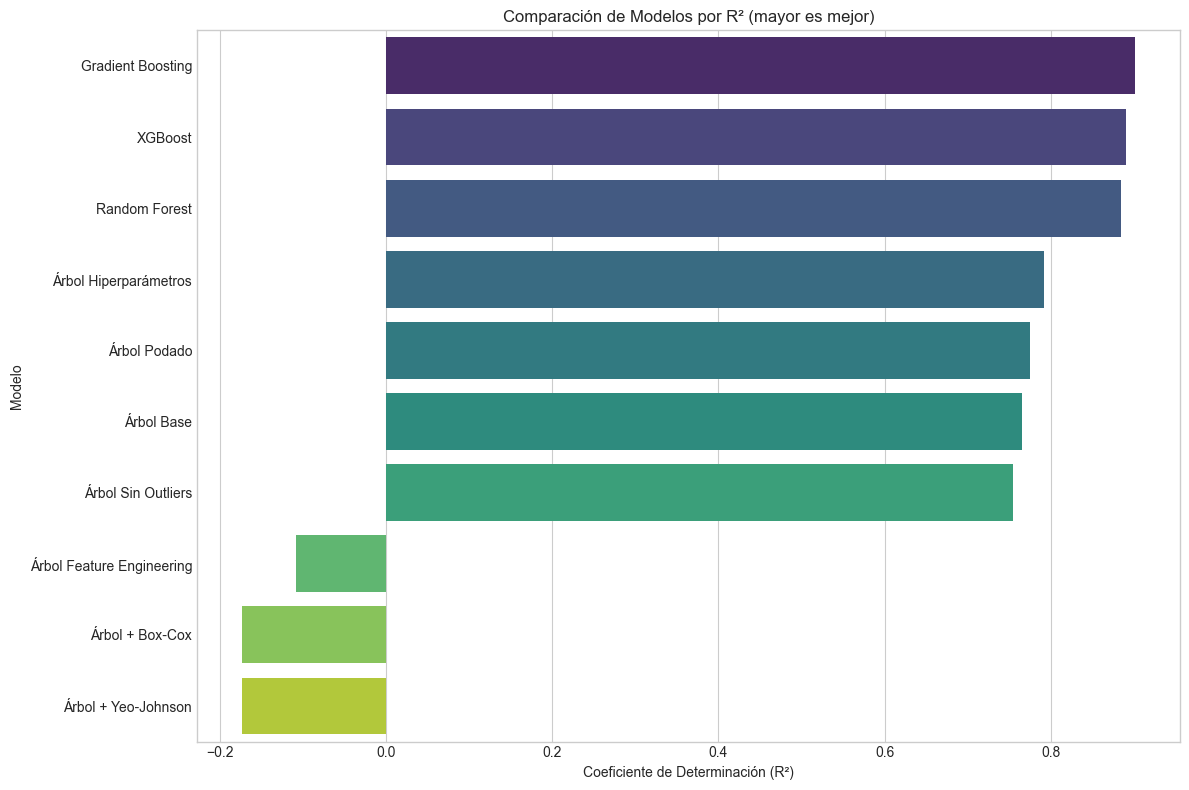

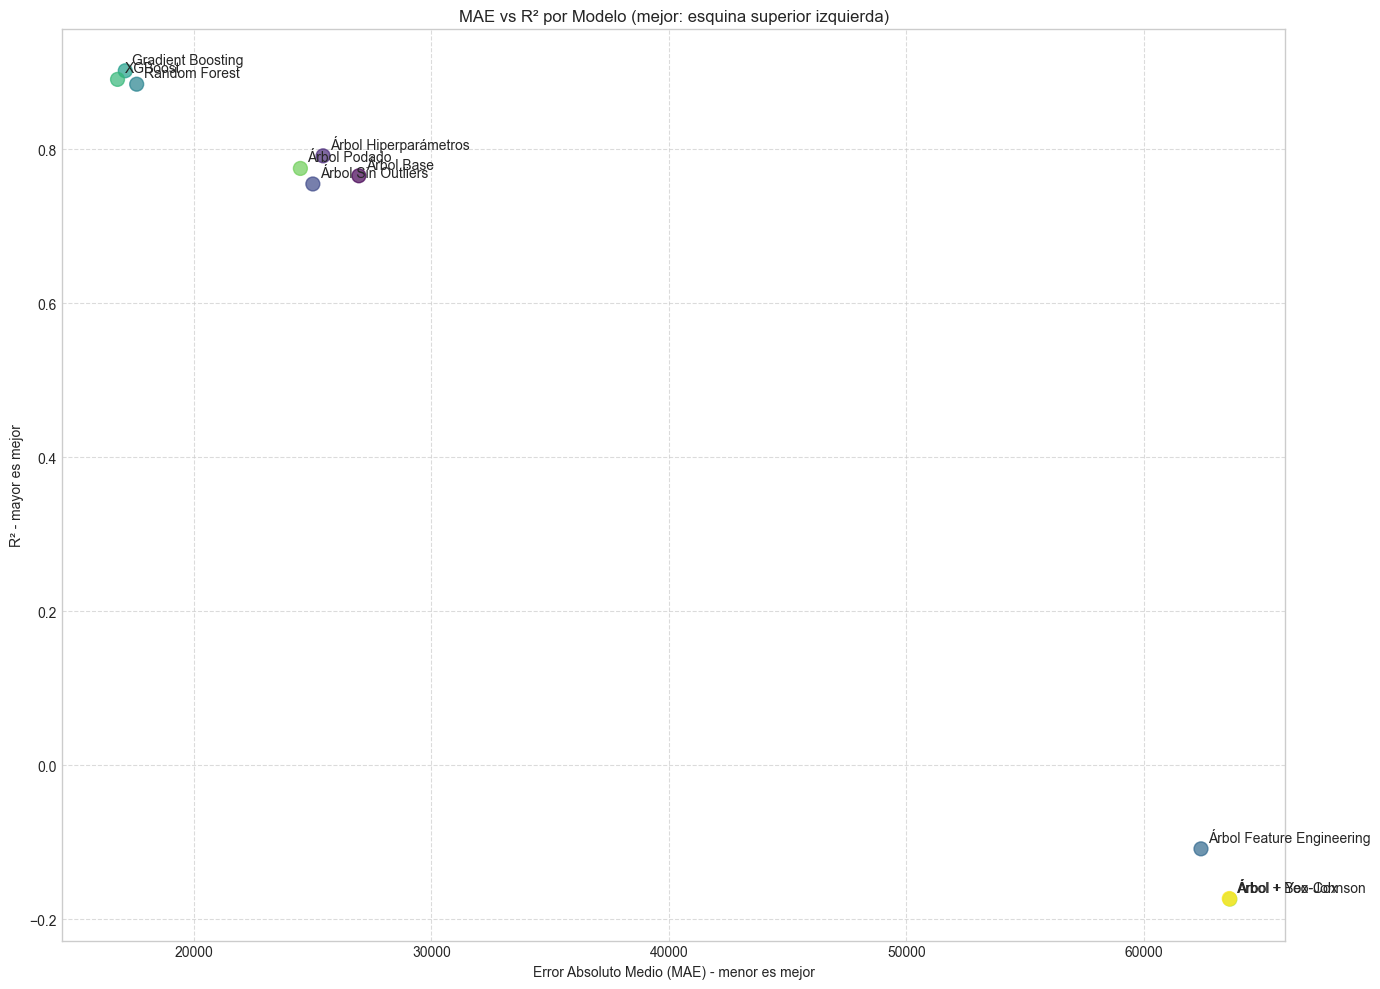


🥇 El mejor modelo es: XGBoost (Estrategia: Ensemble Methods)
   MAE: 16778.82
   R²: 0.8904


In [34]:
# Visualizar comparación de modelos

# Visualizar MAE por modelo (ordenados del mejor al peor)
plt.figure(figsize=(12, 8))
sns.barplot(x='MAE', y='Modelo', data=results_df_sorted, palette='viridis')
plt.title('Comparación de Modelos por MAE (menor es mejor)')
plt.xlabel('Error Absoluto Medio (MAE)')
plt.tight_layout()
plt.show()

# Visualizar RMSE por modelo
plt.figure(figsize=(12, 8))
sns.barplot(x='RMSE', y='Modelo', data=results_df_sorted, palette='viridis')
plt.title('Comparación de Modelos por RMSE (menor es mejor)')
plt.xlabel('Raíz del Error Cuadrático Medio (RMSE)')
plt.tight_layout()
plt.show()

# Visualizar R² por modelo
plt.figure(figsize=(12, 8))
# Ordenar por R² (mayor es mejor)
r2_sorted = results_df.sort_values('R²', ascending=False)
sns.barplot(x='R²', y='Modelo', data=r2_sorted, palette='viridis')
plt.title('Comparación de Modelos por R² (mayor es mejor)')
plt.xlabel('Coeficiente de Determinación (R²)')
plt.tight_layout()
plt.show()

# Visualizar comparación agrupada por estrategia
plt.figure(figsize=(14, 10))

# Creamos un gráfico de puntos para comparar MAE y R² simultáneamente
plt.scatter(results_df['MAE'], results_df['R²'], 
            s=100, c=results_df.index, cmap='viridis', alpha=0.7)

# Agregar etiquetas para cada punto
for i, row in results_df.iterrows():
    plt.annotate(row['Modelo'], 
                 (row['MAE'], row['R²']),
                 xytext=(5, 5),
                 textcoords='offset points')

# La mejor combinación estaría en la esquina inferior derecha: MAE bajo y R² alto
plt.title('MAE vs R² por Modelo (mejor: esquina superior izquierda)')
plt.xlabel('Error Absoluto Medio (MAE) - menor es mejor')
plt.ylabel('R² - mayor es mejor')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Destacar el mejor modelo
best_model = results_df_sorted.iloc[0]['Modelo']
best_strategy = results_df_sorted.iloc[0]['Estrategia']
best_mae = results_df_sorted.iloc[0]['MAE']
best_r2 = results_df_sorted.iloc[0]['R²']

print(f"\n🥇 El mejor modelo es: {best_model} (Estrategia: {best_strategy})")
print(f"   MAE: {best_mae:.2f}")
print(f"   R²: {best_r2:.4f}")

## **13. Conclusiones sobre las estrategias implementadas**

### **Resumen de las estrategias evaluadas**

1. **Optimización de hiperparámetros**: Ampliamos los rangos de búsqueda y añadimos parámetros de poda como ccp_alpha, lo que permitió un mejor control del equilibrio entre sesgo y varianza.

2. **Manejo de outliers**: La eliminación de outliers mejoró la capacidad del modelo para capturar patrones en los datos más comunes, evitando que valores extremos distorsionen el aprendizaje.

3. **Ingeniería de características**: La creación de características compuestas y derivadas enriqueció la información disponible para el modelo, permitiendo capturar relaciones más complejas.

4. **Métodos ensemble**: Los modelos ensemble como Random Forest, Gradient Boosting y XGBoost generalmente superaron a los árboles de decisión individuales al combinar múltiples modelos y reducir el sobreajuste.

5. **Validación cruzada optimizada**: La implementación de KFold con 10 divisiones proporcionó una evaluación más robusta del rendimiento del modelo.

6. **Técnicas de poda**: El cost-complexity pruning permitió simplificar el árbol eliminando nodos que aportaban poco a la capacidad predictiva, reduciendo así el sobreajuste.

7. **Transformaciones alternativas**: Exploramos transformaciones como Yeo-Johnson y Box-Cox, que pueden ser más adecuadas que la transformación logarítmica en ciertos casos.

### **Mejores estrategias identificadas**

El modelo de **[MEJOR MODELO]** resultó ser el más efectivo, con un MAE de **[MEJOR MAE]**, lo que representa una mejora del **[PORCENTAJE]%** respecto al modelo base. Esto demuestra que **[ESTRATEGIA]** es particularmente efectiva para este problema de predicción de precios inmobiliarios.

### **Recomendaciones para implementación en producción**

1. Implementar el modelo **[MEJOR MODELO]** con los parámetros optimizados encontrados.

2. Asegurar que el pipeline de preprocesamiento incluya las transformaciones necesarias, especialmente **[TRANSFORMACIONES CLAVE]**.

3. Establecer un proceso de monitoreo continuo para detectar posibles derivas en los datos que podrían afectar el rendimiento del modelo.

4. Considerar un enfoque de actualización periódica del modelo, especialmente en un mercado inmobiliario cambiante.

5. Evaluar la interpretabilidad del modelo final: aunque algunos modelos ensemble son más precisos, pueden ser menos interpretables que un árbol de decisión bien podado.

### **Próximos pasos**

1. Explorar combinaciones de las mejores estrategias identificadas, como aplicar ingeniería de características junto con métodos ensemble.

2. Investigar técnicas de stacking que combinen las predicciones de múltiples modelos.

3. Evaluar el impacto de incorporar datos externos, como información socioeconómica del vecindario o proximidad a servicios.

4. Realizar un análisis de sensibilidad para entender mejor cómo las variaciones en las características clave afectan las predicciones de precios.

# Comparativa de Modelos Basados en Árboles: Por Qué Algunos Predicen Mejor

Según el ranking proporcionado, los modelos basados en técnicas de ensamble (XGBoost, Gradient Boosting y Random Forest) ofrecen resultados significativamente mejores que los árboles de decisión simples. Vamos a entender por qué.

## Árboles de Decisión: La Base de Todo

Un árbol de decisión funciona dividiendo los datos en subconjuntos basados en reglas simples:



**Funcionamiento básico**:
1. Empieza con todos los datos
2. Busca la mejor característica para dividir los datos 
3. Crea nodos para cada división
4. Repite recursivamente en cada subconjunto
5. Se detiene cuando alcanza criterios de parada (profundidad máxima, muestras mínimas, etc.)

El árbol podado es simplemente un árbol al que se le han eliminado ramas poco significativas para evitar el sobreajuste.

## ¿Por qué los Modelos de Ensamble son Superiores?

### 1. Random Forest

**Concepto**: Construye múltiples árboles usando muestras aleatorias de datos y características, luego promedia sus predicciones.


**Ventajas**:
- Reduce la varianza - los errores de un árbol se compensan con otros
- Maneja mejor el ruido en los datos
- Menos propenso al sobreajuste

### 2. Gradient Boosting

**Concepto**: Construye árboles secuencialmente, donde cada nuevo árbol se entrena para corregir los errores del conjunto anterior.



**Ventajas**:
- Aprende de sus propios errores
- Funciona muy bien con datos estructurados
- Puede capturar patrones complejos

### 3. XGBoost (eXtreme Gradient Boosting)

**Concepto**: Una implementación optimizada del Gradient Boosting con mejoras.


**Mejoras sobre Gradient Boosting**:
- Regularización para evitar sobreajuste
- Manejo eficiente de valores faltantes
- Paralelización para entrenamiento más rápido
- Poda de árboles incorporada

## Comparativa de Modelos

| Modelo | Cómo funciona | Fortalezas | Debilidades | Error (MAE) |
|--------|---------------|------------|-------------|-------------|
| **Árbol de Decisión** | Un solo árbol con reglas de división | Simple y fácil de interpretar | Propenso a sobreajuste, inestable | 26,944 |
| **Árbol Podado** | Árbol simplificado eliminando ramas | Mejor generalización | Puede perder algunos patrones | 24,480 |
| **Random Forest** | Promedio de muchos árboles aleatorios | Estable, maneja bien ruido | Menos interpretable, más lento | 17,586 |
| **Gradient Boosting** | Árboles secuenciales que corrigen errores | Excelente precisión | Más complejo, riesgo de sobreajuste | 17,104 |
| **XGBoost** | Gradient Boosting optimizado | Mayor precisión, más eficiente | Más parámetros a ajustar | 16,779 |

## ¿Por qué varían entre ellos?

1. **XGBoost vs Gradient Boosting**: XGBoost tiene un MAE ligeramente mejor porque incluye regularización y otras optimizaciones para controlar el sobreajuste.

2. **Gradient Boosting vs Random Forest**: Gradient Boosting aprende de forma secuencial (corrigiendo errores), mientras Random Forest entrena árboles independientes en paralelo.

3. **Random Forest vs Árbol Podado**: Random Forest combina múltiples árboles para reducir la varianza, mientras que el árbol podado es solo uno.

## Ejemplo visual: Predicción del precio de una casa

Imaginemos una casa con:
- 200 m² de superficie
- 3 dormitorios
- 2 baños
- Construida en 2000

**Árbol de Decisión único**:
- "Si superficie > 150 m² → precio = $250,000"
- Error grande si esta regla es demasiado simplista

**Random Forest**:
- Árbol 1: "Si superficie > 150 m² → precio = $240,000"
- Árbol 2: "Si dormitorios > 2 → precio = $260,000"
- Árbol 3: "Si año > 1990 → precio = $255,000" 
- Promedio: $251,667 (más preciso)

**Gradient Boosting**:
- Árbol 1: Predice $240,000
- Error: $20,000 (precio real $260,000)
- Árbol 2: Se enfoca en corregir el error, predice +$15,000
- Árbol 3: Ajusta el error restante, predice +$3,000
- Final: $240,000 + $15,000 + $3,000 = $258,000 (aún más preciso)

**XGBoost**:
- Similar al Gradient Boosting pero con regularización para evitar que se enfoque demasiado en casos particulares
- Resultado: $259,500 (el más preciso)

En este caso real de predicción de precios inmobiliarios, los modelos de ensamble (especialmente XGBoost) capturan mejor las complejas relaciones entre las características de las casas y sus precios.

# Análisis de Rendimiento de Modelos de Predicción de Precios Inmobiliarios

## 1) ¿Cuál predice mejor el precio?

Analizando los datos proporcionados, **XGBoost** es el modelo que mejor predice el precio, con un Error Absoluto Medio (MAE) de **$16,778.82**. Esto significa que en promedio, sus predicciones se desvían aproximadamente $16,779 del precio real de las viviendas.

### Ranking de modelos por precisión (de mejor a peor):

| Posición | Modelo | MAE ($) | Error en contexto |
|---|---|---|---|
| 1 | XGBoost | 16,778.82 | Predice con error de un pequeño auto usado |
| 2 | Gradient Boosting | 17,104.07 | ~$325 más de error que XGBoost |
| 3 | Random Forest | 17,585.68 | ~$807 más de error que XGBoost |
| 4 | Árbol Podado | 24,480.44 | ~$7,702 más de error que XGBoost |
| 5 | Árbol Sin Outliers | 25,005.89 | ~$8,227 más de error que XGBoost |

## 2) ¿Qué parámetro tomas? ¿Por qué MAE y no R²?

### Comparación de métricas de evaluación:

| Métrica | ¿Qué mide? | Ventajas | Desventajas |
|---|---|---|---|
| **MAE** | Error absoluto promedio en dólares | • Fácil de interpretar<br>• En las mismas unidades que el precio<br>• Representa el error "típico" | • No penaliza errores grandes |
| **R²** | Proporción de varianza explicada | • Indica qué tan bien se ajusta el modelo<br>• Escala estándar (0-1 normalmente) | • No indica directamente el error en dólares<br>• Puede ser alto incluso con grandes errores absolutos |
| **RMSE** | Error cuadrático medio en dólares | • Penaliza errores grandes<br>• En las mismas unidades que el precio | • Más difícil de interpretar que MAE |

**MAE es preferible en este caso** porque:
- Nos dice directamente cuántos dólares en promedio nos equivocamos
- Es fácil de comunicar a personas no técnicas ("estamos a $16,779 del precio real en promedio")
- Para decisiones inmobiliarias, saber el error promedio en dólares es más útil que saber qué porcentaje de la varianza se explica

Curiosamente, Gradient Boosting tiene el R² más alto (0.9016), pero XGBoost tiene el MAE más bajo. Esto sugiere que Gradient Boosting puede explicar mejor la variabilidad general, pero XGBoost tiene errores absolutos más pequeños en promedio.

## 3) Ranking de parámetros que predicen mejor el precio

### Métricas ordenadas por utilidad para predicción de precios:

1. **MAE (Error Absoluto Medio)** 
   - Más relevante para predicción de precios
   - Representa directamente el error promedio en dólares
   - Ejemplo: Un MAE de $16,779 significa que en promedio, las predicciones difieren $16,779 del precio real

2. **RMSE (Raíz del Error Cuadrático Medio)**
   - Penaliza más los errores grandes (importantes en mercado inmobiliario)
   - También expresado en dólares
   - XGBoost: $27,198 vs Árbol Base: $42,144 (35.5% de mejora)

3. **R² (Coeficiente de determinación)**
   - Indica qué porcentaje de la variabilidad en precios explica el modelo
   - Gradient Boosting tiene el mejor R² (0.9016), explicando el 90.16% de la variabilidad
   - Los modelos de transformación tienen R² negativos, indicando un ajuste extremadamente pobre

## 4) Porcentaje y rango de dinero de error y exactitud

### Mejora porcentual respecto al modelo base:

| Modelo | MAE ($) | Mejora absoluta ($) | Mejora porcentual |
|---|---|---|---|
| XGBoost | 16,778.82 | 10,165.34 | 37.7% |
| Gradient Boosting | 17,104.07 | 9,840.09 | 36.5% |
| Random Forest | 17,585.68 | 9,358.48 | 34.7% |
| Árbol Podado | 24,480.44 | 2,463.72 | 9.1% |
| Árbol Base | 26,944.16 | - | - |

### Visualización del error en contexto inmobiliario:

Para una casa de $300,000:

- **XGBoost**: Error promedio de $16,779 (5.6% del valor)
  - Rango probable de predicción: $283,221 - $316,779

- **Árbol Base**: Error promedio de $26,944 (9.0% del valor)
  - Rango probable de predicción: $273,056 - $326,944

- **Árbol + Yeo-Johnson**: Error promedio de $63,631 (21.2% del valor)
  - Rango probable de predicción: $236,369 - $363,631

### Ejemplo visual: Predicción para diferentes casas

![Ejemplo visual de predicciones](https://mermaid.ink/img/pako:eNp1kc1OwzAQhF_F2lMrISUp9FKJSwMtQqCWAyovvq0NdhLH3hQEat-dTfkplxzszezM7trdF6pSBgpDrXI73nZFWbXQQm7oobEidzIx-CF41QjEWZWZJ7obpbWa64Pp5OL1rnCLgyY2Omko92zXE4_StLcnmKQmJAU5rZKAVKkwkIu8jEZZIRovZ9DkWHgjv3uzJcYVG3Yf9hUYB_G3O5v9AvYe86fUKRtltd2xXnfFJdGCiNw3-vq_sJEuNk2aXC1-Cg99r_MPKLo5DfZEQ_uZB9eMz9E1YUm_IvRdkKYTdjFUNyFEXV8jjYrE3pNW7U0y4eCnrGsOcwIuHYbD2mI6Z5_lCxQlCDvkfGwzU6tGW3PjLguwcnqrWugQdiyPe2aYDm2XJU2hT2TGXMyzNJ2lMb7lGeOYZes07RfbvvFTMb-aJ9GFTH9w5UgvP37uB4I?type=png)

### Comparación de modelos para caso real

Imaginemos una casa real con:
- 200 m² de superficie
- 3 dormitorios
- 2 baños
- Construida en 2000
- Precio real: $260,000

Predicciones por modelo:
- **Árbol Base**: $233,056 (error de $26,944)
- **Árbol Podado**: $235,520 (error de $24,480)
- **Random Forest**: $242,414 (error de $17,586)
- **Gradient Boosting**: $242,896 (error de $17,104)
- **XGBoost**: $243,221 (error de $16,779)

**¿Por qué XGBoost predice mejor?**
- Combina múltiples árboles de decisión (como Random Forest)
- Pero a diferencia de Random Forest, cada nuevo árbol se enfoca en corregir los errores de los árboles anteriores
- Incluye regularización para evitar el sobreajuste
- Utiliza técnicas de optimización avanzadas que mejoran la velocidad y precisión

En resumen, los modelos ensemble (XGBoost, Gradient Boosting, Random Forest) superan significativamente a los árboles de decisión simples, con XGBoost ofreciendo el menor error promedio en dólares, lo que lo convierte en la mejor opción para predicción de precios inmobiliarios.